# 데이터 불러오기

데이터 다운로드 링크 : https://raw.githubusercontent.com/justmarkham/DAT8/master/data/sms.tsv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# SMS Spam 데이터 다운로드 및 로드
url = "https://raw.githubusercontent.com/justmarkham/DAT8/master/data/sms.tsv"
df = pd.read_table(url, header=None, names=['label', 'message'])
df = df.reset_index(drop=True)      # 인덱스 초기화

print('데이터셋 크기:', df.shape)
df.head()

데이터셋 크기: (5572, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [2]:
# gpu설정

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# 데이터 분할

In [3]:
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')          # 문장 토큰화용 데이터 패키지
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [4]:
#@title 라벨변환
df['label'] = df['label'].map({'ham':0, 'spam':1})
texts, labels = df['message'].tolist(), df['label'].tolist()
train_inputs, test_inputs, train_targets, test_targets = train_test_split(texts, labels, test_size=0.2, random_state=42)

print(len(texts))
print(texts[0])

5572
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


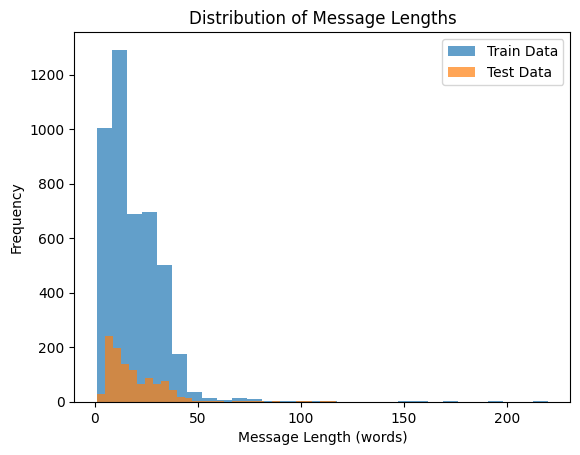

훈련 데이터 평균 길이: 18.85304016154364
훈련 데이터 최대 길이: 220
훈련 데이터 중간값: 18.85304016154364


In [5]:
# 메시지 길이 분포 확인
train_lengths = [len(word_tokenize(msg)) for msg in train_inputs]
test_lengths = [len(word_tokenize(msg)) for msg in test_inputs]

plt.hist(train_lengths, bins=30, alpha=0.7, label='Train Data')
plt.hist(test_lengths, bins=30, alpha=0.7, label='Test Data')
plt.xlabel('Message Length (words)')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Message Lengths')
plt.show()


# 평균 및 최대 길이 확인
print(f"훈련 데이터 평균 길이: {np.mean(train_lengths)}")
print(f"훈련 데이터 최대 길이: {np.max(train_lengths)}")
print(f"훈련 데이터 중간값: {np.mean(train_lengths)}")


In [6]:
# 단어 토큰화
train_sentences = [word_tokenize(msg) for msg in train_inputs]
test_sentences = [word_tokenize(msg) for msg in test_inputs]


In [7]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 63.0 MB/s eta 0:00:00


In [8]:
from gensim.models import Word2Vec

# Word2Vec 모델 학습 및 단어-인덱스 매핑 생성
word2vec_model = Word2Vec(train_sentences, vector_size=50, window=5, min_count=1, sg=1)
word2vec_matrix = np.zeros((len(word2vec_model.wv)+1, 50))
word2idx_word2vec = {word: idx+1 for idx, word in enumerate(word2vec_model.wv.index_to_key)}

for word, idx in word2idx_word2vec.items():
    word2vec_matrix[idx] = word2vec_model.wv[word]

In [9]:
word2vec_model.wv['free']

array([-0.11096059,  0.12806377,  0.11611833, -0.10712439, -0.05668095,
       -0.14744858,  0.4188895 ,  0.71306527, -0.2556406 , -0.09266911,
        0.00128928, -0.45227462,  0.38744527,  0.0144382 , -0.24768943,
        0.27569142,  0.69423383,  0.31140435, -0.55049217, -0.3438073 ,
        0.18345892,  0.3586402 ,  0.6577579 , -0.02265518,  0.47609925,
        0.04972681, -0.10087549,  0.23545167, -0.2873085 ,  0.03828778,
        0.10368746,  0.12112079,  0.02445229, -0.07544644, -0.01143104,
       -0.04979252,  0.27737305,  0.10171765,  0.16779052, -0.3179374 ,
        0.49571237, -0.39983305,  0.05920452,  0.01322418,  0.70898074,
       -0.11922353,  0.18062401, -0.39417458,  0.02680716,  0.32087913],
      dtype=float32)

In [10]:
# 'he'이라는 단어의 벡터 확인
vector = word2vec_model.wv['he']
print(vector)

# 'he'와 가장 유사한 단어 5개 찾기
s_vector = word2vec_model.wv.most_similar('he', topn=5)
print(s_vector)

# 'he' 와 'man'의 유사도 계산
s_vector_cal = word2vec_model.wv.similarity('he', 'man')
print(s_vector_cal)

[ 0.13407905 -0.18980213 -0.50391185  0.29955292 -0.16376163 -0.4746554
  0.24150546  0.86386436 -0.4498745   0.1744424  -0.18373391 -0.6205987
  0.08375878  0.29481336 -0.30282268  0.19256589  0.22066845  0.19455524
 -0.5912734  -0.23813164  0.10004015  0.167983    0.7639076  -0.01180192
  0.46478838 -0.03366775 -0.38269794  0.57435924 -0.5396804  -0.16638361
 -0.14516298 -0.36956465 -0.4947384  -0.36568546 -0.33740187  0.30553398
  0.51631755  0.00610474  0.04258144  0.17811091  0.23093852 -0.20761462
 -0.21118122  0.40779495  1.0730913   0.13623421 -0.06406562 -0.22478966
 -0.14719222  0.31312275]
[('one', 0.9824371337890625), ('sure', 0.9801687002182007), ('she', 0.978386640548706), ('mind', 0.9783179759979248), ('would', 0.9782020449638367)]
0.9168713


In [11]:
class WordSpamDataset(Dataset):
    def __init__(self, texts, labels, word2idx, max_len):
        self.texts = texts
        self.labels = labels
        self.word2idx = word2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = word_tokenize(self.texts[idx])
        encoded = [self.word2idx.get(word, 0) for word in tokens]
        if len(encoded) < self.max_len:
            encoded += [0] *(self.max_len - len(encoded))
        else:
            encoded = encoded[:self.max_len]
        return torch.tensor(encoded, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float)

In [26]:
class EmbeddingLSTM(nn.Module):
  """사전 학습된 임베딩과 LSTM을 사용하여 텍스트를 이진 분류하는 모델"""
  def __init__(self, embedding_matrix, hidden_dim, output_dim, num_layers=2, dropout=0.5):
      super(EmbeddingLSTM, self).__init__()
      num_embeddings, embedding_dim = embedding_matrix.shape
      self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float).to(device), freeze=False)
      self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout)
      self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
      embedded = self.embedding(x)  # 임베딩 레이어를 통과
      _, (hidden, _) = self.lstm(embedded)  # LSTM의 출력
      output = self.fc(hidden[-1])  # 마지막 LSTM 층의 hidden state 사용
      return torch.sigmoid(output)  # sigmoid로 이진 분류


In [27]:
embedding_dim = 50
max_len = 50
hidden_dim = 128
output_dim = 1

In [28]:
# WordSpamDataset 및 데이터 로더
train_dataset_word2vec = WordSpamDataset(train_inputs, train_targets, word2idx_word2vec, max_len)
test_dataset_word2vec = WordSpamDataset(test_inputs, test_targets, word2idx_word2vec, max_len)

train_loader_word2vec = DataLoader(train_dataset_word2vec, batch_size=32, shuffle=True)
test_loader_word2vec = DataLoader(test_dataset_word2vec, batch_size=32, shuffle=False)

In [29]:
# 모델 학습
def train(model, loader, criterion, optimizer):
    """모델을 1 epoch 동안 학습시키킄 함수"""
    model.train()
    total_loss = 0
    for texts, labels in loader:
        texts, labels = texts.to(device), labels.to(device)
        labels = labels.unsqueeze(1)                            # 라벨 크기를 (batch_size, 1)로 변환
        optimizer.zero_grad()
        outputs = model(texts)                                  # 모델 출력 : (batch_size, 1)
        loss = criterion(outputs, labels)                       # 손실계산(BCELoss사용)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)
# 모델 평가
def evaluate(model, loader):
    """모델의 성늘(정확도)을 평가하는 함수"""
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            labels = labels.unsqueeze(1).float()
            outputs = model(texts)
            # 확률값(outputs)이 0.5 이상이면 1(spam), 아니면 0(hem)으로 변환
            predictions = (outputs >= 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [30]:
#모델 초기화
model_word2vec = EmbeddingLSTM(word2vec_matrix, hidden_dim, output_dim).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_word2vec.parameters(), lr=0.001)

In [31]:
# 학습 및 평가 실행
for epoch in range(10):
    loss = train(model_word2vec, train_loader_word2vec, loss_fn, optimizer)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

accuracy = evaluate(model_word2vec, test_loader_word2vec)
print(f"Test Accuracy (Word2Vec with LSTM): {accuracy:.4f}")

Epoch 1, Loss: 0.4185
Epoch 2, Loss: 0.3951
Epoch 3, Loss: 0.2711
Epoch 4, Loss: 0.1332
Epoch 5, Loss: 0.1156
Epoch 6, Loss: 0.1550
Epoch 7, Loss: 0.1496
Epoch 8, Loss: 0.0429
Epoch 9, Loss: 0.0371
Epoch 10, Loss: 0.0191
Test Accuracy (Word2Vec with LSTM): 0.9865


In [32]:
#@title FastText

from gensim.models import FastText

# FastText 모델 학습 및 단어-인덱스 매핑 생성
fasttext_model = FastText(sentences=train_sentences, vector_size=50, window=5, min_count=1, sg=1)
fasttext_matrix = np.zeros((len(fasttext_model.wv) + 1, 50))
word2idx_fasttext = {word: idx + 1 for idx, word in enumerate(fasttext_model.wv.index_to_key)}

for word, idx in word2idx_fasttext.items():
    fasttext_matrix[idx] = fasttext_model.wv[word]

# GloVe
- `glove.6B.100d.txt` 사용


In [34]:
import os
import urllib.request

# GloVe 다운로드 및 임베딩 로드
GLOVE_URL = "https://nlp.stanford.edu/data/glove.6B.zip"
GLOVE_ZIP = "glove.6B.zip"
GLOVE_FILE = "glove.6B.50d.txt"

if not os.path.exists(GLOVE_FILE):
    print("Downloading GloVe embeddings...")
    urllib.request.urlretrieve(GLOVE_URL, GLOVE_ZIP)
    import zipfile
    with zipfile.ZipFile(GLOVE_ZIP, 'r') as zip_ref:
        zip_ref.extractall()
    print("GloVe embeddings downloaded and extracted.")
else:
    print("GloVe embeddings already available.")

GloVe embeddings downloaded and extracted.


In [36]:
embedding_dim = 50
glove_embeddings = {}

with open(GLOVE_FILE, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = coeffs

In [37]:
len(glove_embeddings)

400000

In [38]:
# GloVe word2idx 생성
word2idx_glove = {word: idx + 1 for idx, word in enumerate(glove_embeddings.keys())}
glove_matrix = np.zeros((len(word2idx_glove) + 1, embedding_dim))

for word, idx in word2idx_glove.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        glove_matrix[idx] = embedding_vector

In [39]:
# GloVe Dataset
train_dataset_glove = WordSpamDataset(train_inputs, train_targets, word2idx_glove, max_len)
test_dataset_glove = WordSpamDataset(test_inputs, test_targets, word2idx_glove, max_len)

# GloVe DataLoader
train_loader_glove = DataLoader(train_dataset_glove, batch_size=32, shuffle=True)
test_loader_glove = DataLoader(test_dataset_glove, batch_size=32, shuffle=False)

In [41]:
model_glove = EmbeddingLSTM(glove_matrix, hidden_dim, output_dim).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model_glove.parameters(), lr=0.005)

# 모델 학습
for epoch in range(10):
    loss = train(model_glove, train_loader_glove, loss_fn, optimizer)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

# 모델 평가
accuracy = evaluate(model_glove, test_loader_glove)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1, Loss: 0.4025
Epoch 2, Loss: 0.3062
Epoch 3, Loss: 0.1533
Epoch 4, Loss: 0.0679
Epoch 5, Loss: 0.0467
Epoch 6, Loss: 0.0397
Epoch 7, Loss: 0.0305
Epoch 8, Loss: 0.0170
Epoch 9, Loss: 0.0180
Epoch 10, Loss: 0.0160
Test Accuracy: 0.9803
